In [1]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
%matplotlib inline
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, OneCycleLR

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd


In [2]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [3]:

import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification') # insert ypu kaggle username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tegaakpobaro
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:02<00:00, 60.1MB/s]


In [4]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for facial expression recognition.
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
# Construct datasets.
train_dataset = datasets.ImageFolder("/content/bean-leaf-lesions-classification/train", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/bean-leaf-lesions-classification/test", transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.9
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 1034 samples
Train set has 930 samples
Validation set has 104 samples
Test set has 133 samples


In [6]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 7

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

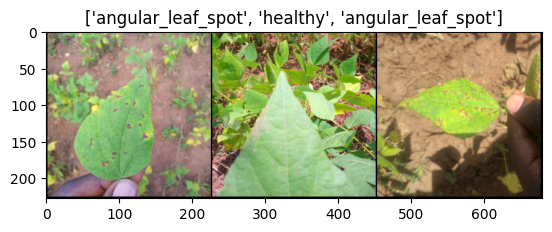

In [7]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=3, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['angular_leaf_spot', 'bean_rust', 'healthy']

imshow(out, title=[class_names[x] for x in classes])

# **MyCNN**- Self made model configuration

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
# The number of training epochs.
n_epochs = 50

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 001/050] Train: loss=1.11410, acc=0.38543 | Valid: loss=0.72913, acc=0.72222


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 002/050] Train: loss=0.74771, acc=0.67866 | Valid: loss=0.89957, acc=0.58730


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 003/050] Train: loss=0.64734, acc=0.73004 | Valid: loss=0.81967, acc=0.72063


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 004/050] Train: loss=0.60498, acc=0.74275 | Valid: loss=0.63035, acc=0.76825


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 005/050] Train: loss=0.49138, acc=0.80290 | Valid: loss=0.56460, acc=0.74127


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 006/050] Train: loss=0.38716, acc=0.84748 | Valid: loss=0.52883, acc=0.78889


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 007/050] Train: loss=0.29809, acc=0.87433 | Valid: loss=0.64505, acc=0.74762


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 008/050] Train: loss=0.27580, acc=0.88382 | Valid: loss=0.47368, acc=0.77778


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 009/050] Train: loss=0.14597, acc=0.95059 | Valid: loss=0.49545, acc=0.79048


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 010/050] Train: loss=0.09206, acc=0.96223 | Valid: loss=0.61719, acc=0.72381


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 011/050] Train: loss=0.06108, acc=0.98496 | Valid: loss=0.61378, acc=0.80635


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 012/050] Train: loss=0.08515, acc=0.96563 | Valid: loss=0.64656, acc=0.78889


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 013/050] Train: loss=0.04859, acc=0.98496 | Valid: loss=0.61225, acc=0.79524


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 014/050] Train: loss=0.05455, acc=0.97959 | Valid: loss=0.78966, acc=0.76032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 015/050] Train: loss=0.00475, acc=1.00000 | Valid: loss=0.77536, acc=0.77778


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 016/050] Train: loss=0.00077, acc=1.00000 | Valid: loss=0.79817, acc=0.78889


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 017/050] Train: loss=0.00048, acc=1.00000 | Valid: loss=0.82767, acc=0.78889


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 018/050] Train: loss=0.00031, acc=1.00000 | Valid: loss=0.84893, acc=0.80635


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 019/050] Train: loss=0.00022, acc=1.00000 | Valid: loss=0.87583, acc=0.80952


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 020/050] Train: loss=0.00016, acc=1.00000 | Valid: loss=0.90851, acc=0.80000


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 021/050] Train: loss=0.00013, acc=1.00000 | Valid: loss=0.94899, acc=0.80476


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 022/050] Train: loss=0.00010, acc=1.00000 | Valid: loss=0.95171, acc=0.80794


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 023/050] Train: loss=0.00008, acc=1.00000 | Valid: loss=1.00991, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 024/050] Train: loss=0.00006, acc=1.00000 | Valid: loss=1.04857, acc=0.79048


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 025/050] Train: loss=0.00004, acc=1.00000 | Valid: loss=1.08185, acc=0.79841


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 026/050] Train: loss=0.00003, acc=1.00000 | Valid: loss=1.16558, acc=0.78889


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 027/050] Train: loss=0.00002, acc=1.00000 | Valid: loss=1.17770, acc=0.79841


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 028/050] Train: loss=0.00002, acc=1.00000 | Valid: loss=1.16516, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 029/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.20813, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 030/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.28365, acc=0.79524


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 031/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.22053, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 032/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.26498, acc=0.80635


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 033/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.25446, acc=0.79841


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 034/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.29016, acc=0.80000


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 035/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.26353, acc=0.78889


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 036/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.31773, acc=0.79841


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 037/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.32263, acc=0.80000


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 038/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.36887, acc=0.79841


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 039/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.38352, acc=0.78730


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 040/050] Train: loss=0.00001, acc=1.00000 | Valid: loss=1.38680, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 041/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.35704, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 042/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.41065, acc=0.80000


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 043/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.46625, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 044/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.48755, acc=0.79841


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 045/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.52173, acc=0.80000


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 046/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.59383, acc=0.79841


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 047/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.56256, acc=0.78730


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 048/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.59936, acc=0.78571


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 049/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.65276, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 050/050] Train: loss=0.00000, acc=1.00000 | Valid: loss=1.62259, acc=0.78730


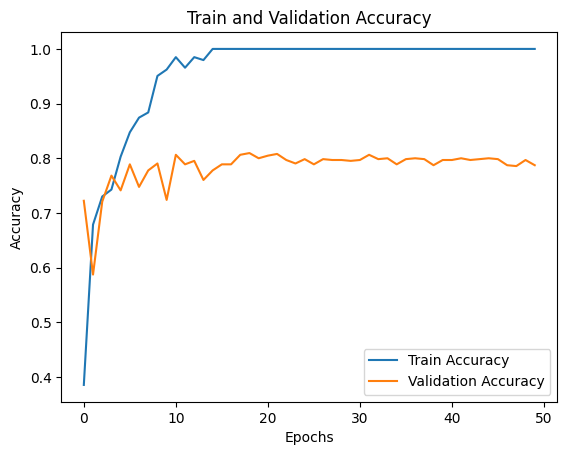

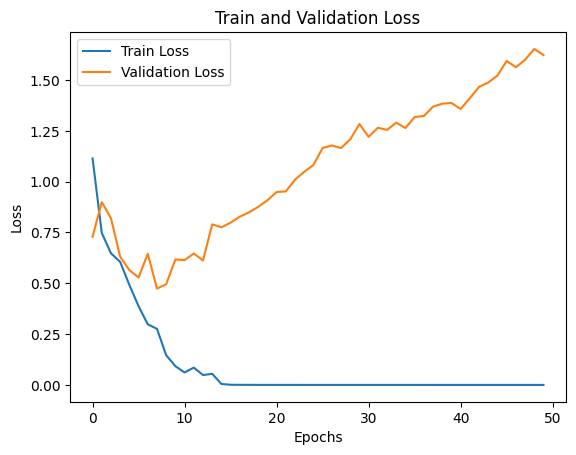

In [ ]:
# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/19 [00:00<?, ?it/s]

Test accuracy 0.7969926595687866


# **AlexNet**

In [ ]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the model
model = AlexNet(num_classes=1000)  # Change 1000 to the number of output classes
print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = AlexNet()
model = model.to(device)

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adamax(model.parameters(), lr=0.0003)

In [ ]:
# The number of training epochs.
n_epochs =50

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 001/050] Train: loss=1.42005, acc=0.32474 | Valid: loss=1.20438, acc=0.30794


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 002/050] Train: loss=1.13298, acc=0.35016 | Valid: loss=1.14847, acc=0.30794


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 003/050] Train: loss=1.12627, acc=0.34390 | Valid: loss=1.10475, acc=0.34603


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 004/050] Train: loss=1.12137, acc=0.32152 | Valid: loss=1.04328, acc=0.49048


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 005/050] Train: loss=1.01229, acc=0.47870 | Valid: loss=1.02129, acc=0.46032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 006/050] Train: loss=0.90210, acc=0.55854 | Valid: loss=0.92093, acc=0.58571


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 007/050] Train: loss=0.86260, acc=0.62245 | Valid: loss=0.80784, acc=0.70317


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 008/050] Train: loss=0.80339, acc=0.66667 | Valid: loss=0.82023, acc=0.66190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 009/050] Train: loss=0.69867, acc=0.69996 | Valid: loss=0.78937, acc=0.62698


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 010/050] Train: loss=0.70086, acc=0.70856 | Valid: loss=0.61059, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 011/050] Train: loss=0.61835, acc=0.73648 | Valid: loss=0.66977, acc=0.74286


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 012/050] Train: loss=0.59728, acc=0.74096 | Valid: loss=0.57657, acc=0.78730


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 013/050] Train: loss=0.55348, acc=0.76011 | Valid: loss=0.58595, acc=0.77619


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 014/050] Train: loss=0.51587, acc=0.76799 | Valid: loss=0.73130, acc=0.73968


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 015/050] Train: loss=0.49789, acc=0.76459 | Valid: loss=0.56760, acc=0.82698


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 016/050] Train: loss=0.44083, acc=0.80845 | Valid: loss=0.53156, acc=0.82857


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 017/050] Train: loss=0.41225, acc=0.81812 | Valid: loss=0.57684, acc=0.81429


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 018/050] Train: loss=0.37906, acc=0.83960 | Valid: loss=0.63420, acc=0.78095


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 019/050] Train: loss=0.36007, acc=0.83459 | Valid: loss=0.48923, acc=0.84762


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 020/050] Train: loss=0.31595, acc=0.86627 | Valid: loss=0.51600, acc=0.81746


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 021/050] Train: loss=0.31167, acc=0.86985 | Valid: loss=0.60056, acc=0.82381


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 022/050] Train: loss=0.23209, acc=0.90834 | Valid: loss=0.65737, acc=0.75079


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 023/050] Train: loss=0.24561, acc=0.89241 | Valid: loss=0.53987, acc=0.80635


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 024/050] Train: loss=0.19388, acc=0.92016 | Valid: loss=0.69677, acc=0.77778


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 025/050] Train: loss=0.16334, acc=0.93663 | Valid: loss=0.55532, acc=0.78889


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 026/050] Train: loss=0.18659, acc=0.92248 | Valid: loss=0.69150, acc=0.81587


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 027/050] Train: loss=0.11935, acc=0.94415 | Valid: loss=0.69387, acc=0.79683


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 028/050] Train: loss=0.10362, acc=0.96241 | Valid: loss=0.67528, acc=0.83651


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 029/050] Train: loss=0.10050, acc=0.95489 | Valid: loss=0.62243, acc=0.83651


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 030/050] Train: loss=0.04732, acc=0.98496 | Valid: loss=0.79841, acc=0.83492


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 031/050] Train: loss=0.04467, acc=0.98389 | Valid: loss=0.74187, acc=0.82857


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 032/050] Train: loss=0.06517, acc=0.97422 | Valid: loss=0.79698, acc=0.80794


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 033/050] Train: loss=0.03690, acc=0.98908 | Valid: loss=0.87996, acc=0.84762


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 034/050] Train: loss=0.11642, acc=0.95596 | Valid: loss=0.73644, acc=0.77937


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 035/050] Train: loss=0.06417, acc=0.97852 | Valid: loss=1.02136, acc=0.80635


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 036/050] Train: loss=0.02104, acc=0.99570 | Valid: loss=0.80407, acc=0.87460


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 037/050] Train: loss=0.00323, acc=1.00000 | Valid: loss=0.91178, acc=0.89365


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 038/050] Train: loss=0.00139, acc=1.00000 | Valid: loss=0.92682, acc=0.86508


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 039/050] Train: loss=0.00201, acc=1.00000 | Valid: loss=1.00683, acc=0.87460


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 040/050] Train: loss=0.05049, acc=0.97959 | Valid: loss=0.73947, acc=0.84762


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 041/050] Train: loss=0.05555, acc=0.98067 | Valid: loss=0.85839, acc=0.87619


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 042/050] Train: loss=0.04718, acc=0.98281 | Valid: loss=0.80823, acc=0.86667


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 043/050] Train: loss=0.00475, acc=1.00000 | Valid: loss=0.91342, acc=0.84603


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 044/050] Train: loss=0.00146, acc=1.00000 | Valid: loss=0.98773, acc=0.87619


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 045/050] Train: loss=0.00051, acc=1.00000 | Valid: loss=1.02375, acc=0.86508


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 046/050] Train: loss=0.00249, acc=0.99893 | Valid: loss=1.74880, acc=0.76508


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 047/050] Train: loss=0.05940, acc=0.97852 | Valid: loss=0.84557, acc=0.86508


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 048/050] Train: loss=0.00319, acc=1.00000 | Valid: loss=0.67660, acc=0.87619


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 049/050] Train: loss=0.00083, acc=1.00000 | Valid: loss=0.79107, acc=0.87619


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 050/050] Train: loss=0.00041, acc=1.00000 | Valid: loss=0.87454, acc=0.87302


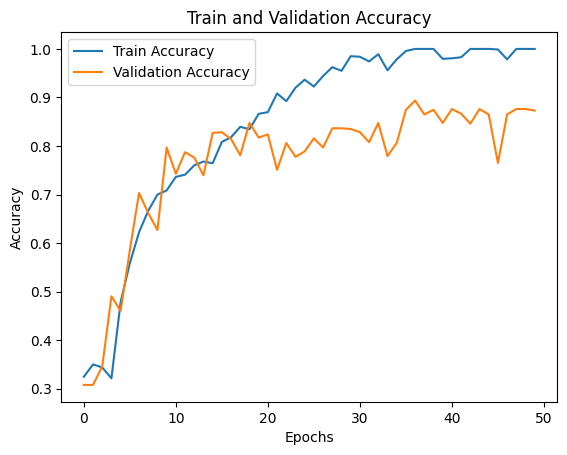

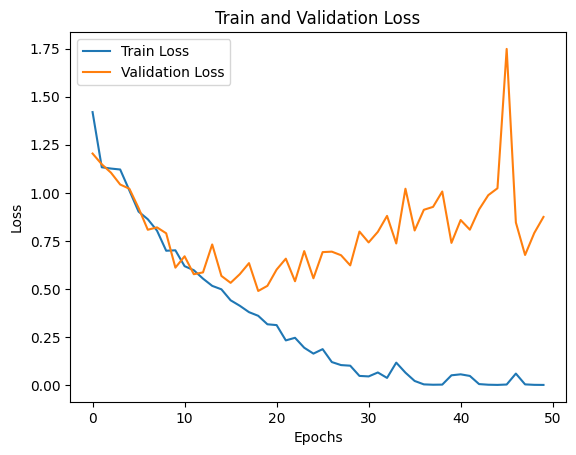

In [ ]:
# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/19 [00:00<?, ?it/s]

Test accuracy 0.8721805214881897


# **EFFICIENTNET**

In [8]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [9]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetCustom, self).__init__()
        # Load pre-trained EfficientNet-B0
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        # Modify the classifier
        in_features = self.model._fc.in_features
        self.model._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Define the number of classes for bean leaf lesion classification
num_classes = 10  # Change this to the actual number of classes
model = EfficientNetCustom(num_classes=num_classes)

# Print the model architecture
print(model)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 228MB/s]

Loaded pretrained weights for efficientnet-b0
EfficientNetCustom(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
       

In [10]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = EfficientNetCustom(num_classes = 10)
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [11]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [12]:
# The number of training epochs.
n_epochs =50

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 001/050] Train: loss=0.70880, acc=0.77855 | Valid: loss=1.10361, acc=0.64286


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 002/050] Train: loss=0.24349, acc=0.91586 | Valid: loss=0.34475, acc=0.88413


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 003/050] Train: loss=0.10925, acc=0.96008 | Valid: loss=0.22170, acc=0.92381


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 004/050] Train: loss=0.08904, acc=0.97207 | Valid: loss=0.25054, acc=0.93333


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 005/050] Train: loss=0.06896, acc=0.98067 | Valid: loss=0.35812, acc=0.93968


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 006/050] Train: loss=0.07104, acc=0.97834 | Valid: loss=0.15631, acc=0.94286


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 007/050] Train: loss=0.10019, acc=0.96867 | Valid: loss=0.38784, acc=0.84603


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 008/050] Train: loss=0.07492, acc=0.97637 | Valid: loss=0.22196, acc=0.93175


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 009/050] Train: loss=0.05877, acc=0.98496 | Valid: loss=0.15919, acc=0.93175


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 010/050] Train: loss=0.05189, acc=0.98496 | Valid: loss=0.16134, acc=0.94127


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 011/050] Train: loss=0.03814, acc=0.99033 | Valid: loss=0.21481, acc=0.92381


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 012/050] Train: loss=0.05275, acc=0.98496 | Valid: loss=0.17898, acc=0.96032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 013/050] Train: loss=0.02045, acc=0.99570 | Valid: loss=0.20071, acc=0.96190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 014/050] Train: loss=0.02081, acc=0.99463 | Valid: loss=0.32003, acc=0.93333


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 015/050] Train: loss=0.01095, acc=0.99785 | Valid: loss=0.18602, acc=0.95238


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 016/050] Train: loss=0.00652, acc=0.99785 | Valid: loss=0.27195, acc=0.91429


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 017/050] Train: loss=0.01607, acc=0.99356 | Valid: loss=0.21705, acc=0.93333


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 018/050] Train: loss=0.00603, acc=0.99785 | Valid: loss=0.11796, acc=0.96984


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 019/050] Train: loss=0.00519, acc=0.99893 | Valid: loss=0.09452, acc=0.96032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 020/050] Train: loss=0.06774, acc=0.97959 | Valid: loss=0.27509, acc=0.94286


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 021/050] Train: loss=0.08064, acc=0.97530 | Valid: loss=0.36787, acc=0.89524


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 022/050] Train: loss=0.03838, acc=0.98818 | Valid: loss=0.27931, acc=0.93333


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 023/050] Train: loss=0.02674, acc=0.99033 | Valid: loss=0.19013, acc=0.94286


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 024/050] Train: loss=0.01936, acc=0.99678 | Valid: loss=0.17431, acc=0.96190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 025/050] Train: loss=0.01117, acc=0.99678 | Valid: loss=0.26759, acc=0.93333


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 026/050] Train: loss=0.02251, acc=0.99570 | Valid: loss=0.05290, acc=0.98095


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 027/050] Train: loss=0.03860, acc=0.99356 | Valid: loss=0.11940, acc=0.94127


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 028/050] Train: loss=0.02493, acc=0.99893 | Valid: loss=0.09015, acc=0.96190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 029/050] Train: loss=0.01025, acc=0.99785 | Valid: loss=0.15656, acc=0.94127


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 030/050] Train: loss=0.00857, acc=0.99678 | Valid: loss=0.13064, acc=0.95079


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 031/050] Train: loss=0.02972, acc=0.99248 | Valid: loss=0.13261, acc=0.96032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 032/050] Train: loss=0.00912, acc=0.99893 | Valid: loss=0.18028, acc=0.94127


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 033/050] Train: loss=0.02732, acc=0.99033 | Valid: loss=0.15536, acc=0.97143


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 034/050] Train: loss=0.01494, acc=0.99678 | Valid: loss=0.04321, acc=0.98095


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 035/050] Train: loss=0.00285, acc=0.99893 | Valid: loss=0.02375, acc=0.99048


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 036/050] Train: loss=0.00356, acc=0.99785 | Valid: loss=0.09343, acc=0.97143


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 037/050] Train: loss=0.00471, acc=0.99893 | Valid: loss=0.06548, acc=0.98095


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 038/050] Train: loss=0.01248, acc=0.99570 | Valid: loss=0.15602, acc=0.96032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 039/050] Train: loss=0.02402, acc=0.99570 | Valid: loss=0.07946, acc=0.97143


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 040/050] Train: loss=0.00531, acc=0.99785 | Valid: loss=0.06463, acc=0.96032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 041/050] Train: loss=0.01400, acc=0.99338 | Valid: loss=0.10421, acc=0.97143


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 042/050] Train: loss=0.01314, acc=0.99785 | Valid: loss=0.14917, acc=0.95238


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 043/050] Train: loss=0.01299, acc=0.99785 | Valid: loss=0.14021, acc=0.96190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 044/050] Train: loss=0.02925, acc=0.99033 | Valid: loss=0.11448, acc=0.94286


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 045/050] Train: loss=0.02055, acc=0.99141 | Valid: loss=0.13386, acc=0.98095


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 046/050] Train: loss=0.00706, acc=0.99893 | Valid: loss=0.13703, acc=0.98095


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 047/050] Train: loss=0.03647, acc=0.99033 | Valid: loss=0.48165, acc=0.96032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 048/050] Train: loss=0.01995, acc=0.99033 | Valid: loss=0.17007, acc=0.95238


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 049/050] Train: loss=0.00811, acc=0.99678 | Valid: loss=0.17198, acc=0.96190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 050/050] Train: loss=0.00315, acc=1.00000 | Valid: loss=0.25752, acc=0.94286


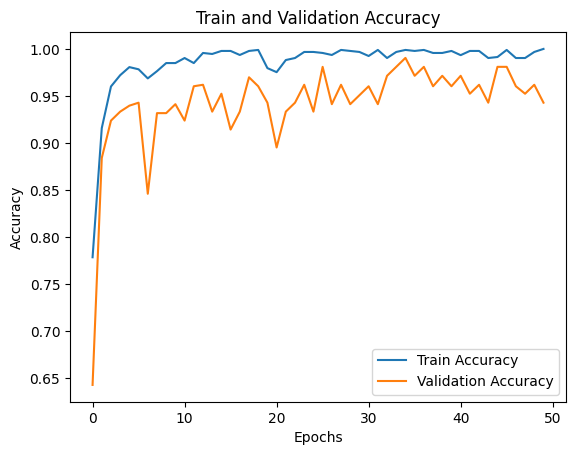

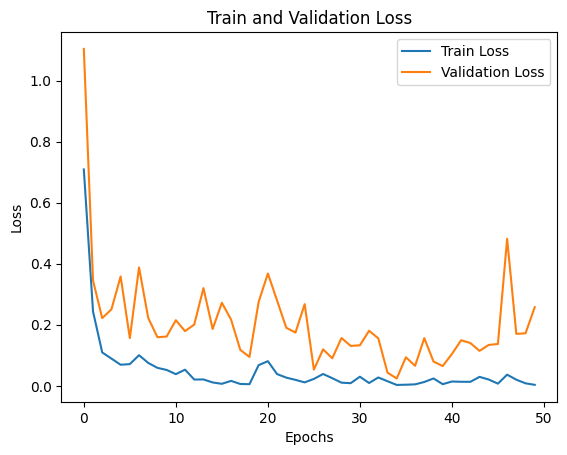

In [13]:
# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [14]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/19 [00:00<?, ?it/s]

Test accuracy 0.9774436950683594


# **DENSENET121**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out, x], 1)
        return out

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = self.pool(out)
        return out

class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=32, reduction=0.5, num_classes=1000):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_channels = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.features = nn.Sequential()

        for i in range(len(nblocks)):
            self.features.add_module('dense_block_layer_{}'.format(i), self._make_dense_layers(block, num_channels, nblocks[i]))
            num_channels += nblocks[i] * growth_rate
            if i != len(nblocks) - 1:
                out_channels = int(num_channels * reduction)
                self.features.add_module('transition_layer_{}'.format(i), Transition(num_channels, out_channels))
                num_channels = out_channels

        self.bn2 = nn.BatchNorm2d(num_channels)
        self.fc = nn.Linear(num_channels, num_classes)

    def _make_dense_layers(self, block, in_channels, nblocks):
        layers = []
        for i in range(nblocks):
            layers.append(block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.pool1(F.relu(self.bn1(self.conv1(x))))
        out = self.features(out)
        out = F.relu(self.bn2(out))
        out = F.avg_pool2d(out, 7).view(out.size(0), -1)
        out = self.fc(out)
        return out

def densenet121():
    return DenseNet(Bottleneck, [6, 12, 24, 16], growth_rate=32)

# Instantiate and print the model
model = densenet121()
print(model)


DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (features): Sequential(
    (dense_block_layer_0): Sequential(
      (0): Bottleneck(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Bottleneck(
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = densenet121()
model = model.to(device)

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
# The number of training epochs.
n_epochs = 50

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 001/050] Train: loss=1.45291, acc=0.60634 | Valid: loss=0.67013, acc=0.73175


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 002/050] Train: loss=0.78915, acc=0.66022 | Valid: loss=0.65489, acc=0.73016


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 003/050] Train: loss=0.74225, acc=0.67293 | Valid: loss=1.28839, acc=0.62698


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 004/050] Train: loss=0.73397, acc=0.69710 | Valid: loss=0.73429, acc=0.74127


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 005/050] Train: loss=0.68178, acc=0.72342 | Valid: loss=0.63771, acc=0.77937


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 006/050] Train: loss=0.63281, acc=0.74293 | Valid: loss=2.72105, acc=0.49206


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 007/050] Train: loss=0.57927, acc=0.75116 | Valid: loss=2.79796, acc=0.45238


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 008/050] Train: loss=0.56907, acc=0.76566 | Valid: loss=1.84482, acc=0.54762


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 009/050] Train: loss=0.52873, acc=0.80541 | Valid: loss=0.74601, acc=0.73016


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 010/050] Train: loss=0.44406, acc=0.81078 | Valid: loss=0.70828, acc=0.73016


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 011/050] Train: loss=0.44704, acc=0.80881 | Valid: loss=0.41376, acc=0.78730


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 012/050] Train: loss=0.41440, acc=0.84193 | Valid: loss=0.39978, acc=0.80794


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 013/050] Train: loss=0.37633, acc=0.85804 | Valid: loss=0.32395, acc=0.87302


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 014/050] Train: loss=0.35809, acc=0.84962 | Valid: loss=0.31814, acc=0.84603


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 015/050] Train: loss=0.34791, acc=0.86663 | Valid: loss=0.31750, acc=0.86508


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 016/050] Train: loss=0.31146, acc=0.88274 | Valid: loss=0.27454, acc=0.88571


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 017/050] Train: loss=0.27257, acc=0.90422 | Valid: loss=0.20364, acc=0.93175


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 018/050] Train: loss=0.32833, acc=0.86896 | Valid: loss=0.26214, acc=0.88571


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 019/050] Train: loss=0.29556, acc=0.88919 | Valid: loss=0.30772, acc=0.87460


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 020/050] Train: loss=0.28810, acc=0.88937 | Valid: loss=0.34398, acc=0.82857


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 021/050] Train: loss=0.26961, acc=0.90118 | Valid: loss=0.55161, acc=0.81905


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 022/050] Train: loss=0.21231, acc=0.91497 | Valid: loss=0.37790, acc=0.86667


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 023/050] Train: loss=0.22172, acc=0.90655 | Valid: loss=0.23414, acc=0.92381


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 024/050] Train: loss=0.20308, acc=0.92141 | Valid: loss=0.32558, acc=0.86667


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 025/050] Train: loss=0.22075, acc=0.91944 | Valid: loss=0.42052, acc=0.87619


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 026/050] Train: loss=0.24312, acc=0.90977 | Valid: loss=0.36330, acc=0.86190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 027/050] Train: loss=0.22525, acc=0.92141 | Valid: loss=0.27288, acc=0.90476


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 028/050] Train: loss=0.15191, acc=0.93842 | Valid: loss=0.24074, acc=0.91270


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 029/050] Train: loss=0.19712, acc=0.93018 | Valid: loss=0.31039, acc=0.87302


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 030/050] Train: loss=0.14225, acc=0.94307 | Valid: loss=0.24842, acc=0.90476


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 031/050] Train: loss=0.11955, acc=0.95166 | Valid: loss=0.22070, acc=0.92222


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 032/050] Train: loss=0.16044, acc=0.94415 | Valid: loss=0.56105, acc=0.76032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 033/050] Train: loss=0.18014, acc=0.93770 | Valid: loss=0.27950, acc=0.85556


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 034/050] Train: loss=0.17033, acc=0.94576 | Valid: loss=0.46439, acc=0.82540


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 035/050] Train: loss=0.11307, acc=0.95883 | Valid: loss=0.24792, acc=0.88413


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 036/050] Train: loss=0.13537, acc=0.95023 | Valid: loss=0.47361, acc=0.84762


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 037/050] Train: loss=0.09624, acc=0.96885 | Valid: loss=0.24678, acc=0.91429


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 038/050] Train: loss=0.13166, acc=0.96026 | Valid: loss=0.46185, acc=0.82540


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 039/050] Train: loss=0.11955, acc=0.95166 | Valid: loss=0.20515, acc=0.92381


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 040/050] Train: loss=0.11825, acc=0.95704 | Valid: loss=0.22146, acc=0.91429


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 041/050] Train: loss=0.11558, acc=0.96455 | Valid: loss=0.39000, acc=0.87619


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 042/050] Train: loss=0.14186, acc=0.95811 | Valid: loss=1.40025, acc=0.55714


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 043/050] Train: loss=0.13426, acc=0.94844 | Valid: loss=0.23700, acc=0.91429


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 044/050] Train: loss=0.11065, acc=0.96867 | Valid: loss=0.28257, acc=0.90476


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 045/050] Train: loss=0.09788, acc=0.96867 | Valid: loss=0.31272, acc=0.89524


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 046/050] Train: loss=0.07065, acc=0.97959 | Valid: loss=0.27273, acc=0.90476


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 047/050] Train: loss=0.06933, acc=0.97744 | Valid: loss=0.16796, acc=0.92222


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 048/050] Train: loss=0.12984, acc=0.95274 | Valid: loss=0.50797, acc=0.83492


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 049/050] Train: loss=0.07664, acc=0.97207 | Valid: loss=0.33751, acc=0.88571


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 050/050] Train: loss=0.07335, acc=0.97207 | Valid: loss=0.29687, acc=0.90476


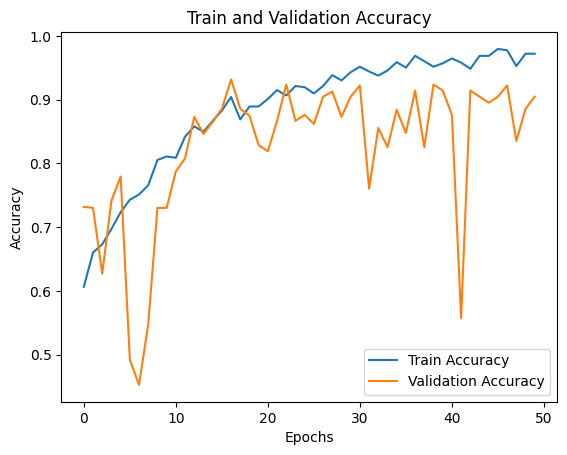

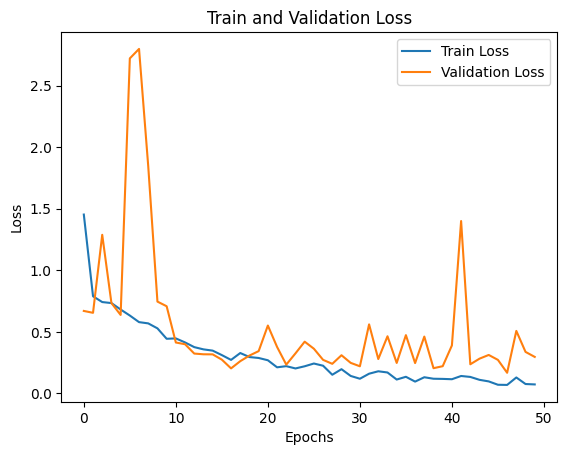

In [ ]:
# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/19 [00:00<?, ?it/s]

Test accuracy 0.9248121380805969


# **ResNet50**

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = torch.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = torch.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = torch.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

# Instantiate and print the model
model = resnet50(num_classes=10)  # Change 10 to the number of output classes
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Batc

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = resnet50()
model = model.to(device)

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
# The number of training epochs.
n_epochs = 50

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 001/050] Train: loss=1.27853, acc=0.50358 | Valid: loss=0.94530, acc=0.66190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 002/050] Train: loss=0.88708, acc=0.59792 | Valid: loss=0.86510, acc=0.62540


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 003/050] Train: loss=0.76976, acc=0.65342 | Valid: loss=0.76106, acc=0.72063


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 004/050] Train: loss=0.79928, acc=0.66416 | Valid: loss=0.71900, acc=0.69365


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 005/050] Train: loss=0.73159, acc=0.68278 | Valid: loss=1.84034, acc=0.44286


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 006/050] Train: loss=0.72527, acc=0.70659 | Valid: loss=0.70321, acc=0.74127


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 007/050] Train: loss=0.66518, acc=0.73416 | Valid: loss=0.85709, acc=0.76032


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 008/050] Train: loss=0.59601, acc=0.74866 | Valid: loss=0.67443, acc=0.75079


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 009/050] Train: loss=0.52034, acc=0.78822 | Valid: loss=0.43435, acc=0.79048


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 010/050] Train: loss=0.48294, acc=0.80648 | Valid: loss=1.45139, acc=0.55556


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 011/050] Train: loss=0.45468, acc=0.81078 | Valid: loss=0.45000, acc=0.82698


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 012/050] Train: loss=0.44223, acc=0.83190 | Valid: loss=0.39078, acc=0.84603


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 013/050] Train: loss=0.42701, acc=0.83190 | Valid: loss=0.46334, acc=0.82540


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 014/050] Train: loss=0.37382, acc=0.85374 | Valid: loss=0.68355, acc=0.73175


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 015/050] Train: loss=0.32086, acc=0.87630 | Valid: loss=0.37413, acc=0.85714


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 016/050] Train: loss=0.32115, acc=0.88919 | Valid: loss=1.41826, acc=0.56190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 017/050] Train: loss=0.32136, acc=0.87863 | Valid: loss=0.42943, acc=0.81746


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 018/050] Train: loss=0.23463, acc=0.91300 | Valid: loss=1.52307, acc=0.70476


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 019/050] Train: loss=0.25868, acc=0.89671 | Valid: loss=0.34428, acc=0.86349


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 020/050] Train: loss=0.29979, acc=0.87863 | Valid: loss=0.36126, acc=0.85714


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 021/050] Train: loss=0.21394, acc=0.91711 | Valid: loss=0.55994, acc=0.80635


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 022/050] Train: loss=0.18072, acc=0.93448 | Valid: loss=0.36212, acc=0.84444


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 023/050] Train: loss=0.16472, acc=0.94092 | Valid: loss=0.49862, acc=0.84603


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 024/050] Train: loss=0.21959, acc=0.91604 | Valid: loss=0.39920, acc=0.82857


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 025/050] Train: loss=0.16118, acc=0.94253 | Valid: loss=0.62573, acc=0.78730


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 026/050] Train: loss=0.21636, acc=0.92052 | Valid: loss=0.46872, acc=0.82857


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 027/050] Train: loss=0.19650, acc=0.92463 | Valid: loss=0.41242, acc=0.82381


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 028/050] Train: loss=0.13319, acc=0.95381 | Valid: loss=0.45060, acc=0.85556


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 029/050] Train: loss=0.13652, acc=0.95274 | Valid: loss=0.87805, acc=0.76984


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 030/050] Train: loss=0.17466, acc=0.93663 | Valid: loss=0.29287, acc=0.88413


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 031/050] Train: loss=0.10445, acc=0.95900 | Valid: loss=0.56916, acc=0.80000


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 032/050] Train: loss=0.15784, acc=0.93878 | Valid: loss=0.49023, acc=0.82540


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 033/050] Train: loss=0.06268, acc=0.97744 | Valid: loss=0.41045, acc=0.82698


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 034/050] Train: loss=0.11731, acc=0.95274 | Valid: loss=0.62420, acc=0.80952


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 035/050] Train: loss=0.09254, acc=0.96455 | Valid: loss=0.43395, acc=0.83333


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 036/050] Train: loss=0.09746, acc=0.96670 | Valid: loss=0.29525, acc=0.88571


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 037/050] Train: loss=0.09872, acc=0.95900 | Valid: loss=0.43758, acc=0.84762


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 038/050] Train: loss=0.03378, acc=0.98818 | Valid: loss=0.38381, acc=0.86190


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 039/050] Train: loss=0.02046, acc=0.99463 | Valid: loss=0.32345, acc=0.84762


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 040/050] Train: loss=0.08553, acc=0.96670 | Valid: loss=0.99960, acc=0.73016


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 041/050] Train: loss=0.08439, acc=0.96348 | Valid: loss=0.74617, acc=0.81746


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 042/050] Train: loss=0.13989, acc=0.94289 | Valid: loss=0.30728, acc=0.92222


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 043/050] Train: loss=0.10062, acc=0.95811 | Valid: loss=0.58165, acc=0.79841


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 044/050] Train: loss=0.04325, acc=0.98478 | Valid: loss=0.40919, acc=0.83810


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 045/050] Train: loss=0.10288, acc=0.96455 | Valid: loss=0.67314, acc=0.83492


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 046/050] Train: loss=0.09983, acc=0.96652 | Valid: loss=0.62455, acc=0.77937


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 047/050] Train: loss=0.05216, acc=0.98281 | Valid: loss=0.51642, acc=0.81587


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 048/050] Train: loss=0.10822, acc=0.96241 | Valid: loss=0.54288, acc=0.80000


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 049/050] Train: loss=0.04815, acc=0.98389 | Valid: loss=0.48665, acc=0.86508


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 050/050] Train: loss=0.00998, acc=0.99785 | Valid: loss=0.24554, acc=0.89206


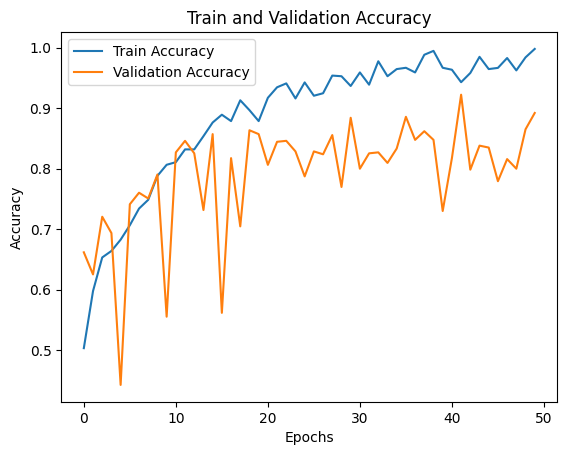

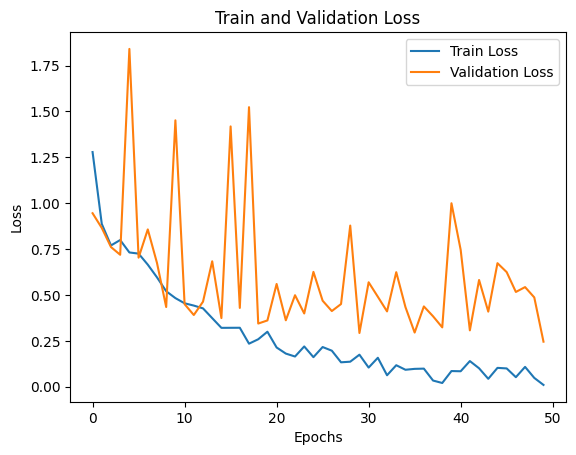

In [ ]:
# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/19 [00:00<?, ?it/s]

Test accuracy 0.9022558331489563


# **Optimization on EfficientNetCustom**

We want to test other optimizers on our best model to check if the model will perform better.

For this test we will apply our default optimizer 'adam' alongside adamax and sgd.

Scoring will still be valid loss and valid accuracy.

In [15]:
def train(model, train_loader, optimizer, criterion, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def eval(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [16]:
# Define the optimizers to be used
num_classes = 10  # Change this to the actual number of classes
model = EfficientNetCustom(num_classes=num_classes)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()

sgd_optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
adamax_optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Define the list of optimizers and their names
optimizers = [(sgd_optimizer, 'SGD'), (adamax_optimizer, 'Adamax'), (adam_optimizer, 'Adam')]
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 40
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH



train_losses = [[] for _ in range(len(optimizers))]
valid_losses = [[] for _ in range(len(optimizers))]
train_accs = [[] for _ in range(len(optimizers))]
valid_accs = [[] for _ in range(len(optimizers))]

best_valid_loss = {optimizer_name: float('inf') for _, optimizer_name in optimizers}
best_valid_acc = {optimizer_name: 0.0 for _, optimizer_name in optimizers}

# Define early stopping parameters
early_stopping_rounds = 10

# Loop over the optimizers and fit the model
for i, (optimizer, optimizer_name) in enumerate(optimizers):

    print(f"\n------------ \n Using  {optimizer_name} optimizer \n")

    # Reset early stopping parameters for each optimizer
    early_stopping_counter = 0

    for epoch in range(EPOCHS):

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, scheduler, device)
        valid_loss, valid_acc = eval(model, valid_loader, criterion, device)

        train_losses[i].append(train_loss)
        valid_losses[i].append(valid_loss)
        train_accs[i].append(train_acc)
        valid_accs[i].append(valid_acc)

        if valid_loss < best_valid_loss[optimizer_name]:
            # Update the best validation loss and reset the early stopping counter
            best_valid_loss[optimizer_name] = valid_loss
            early_stopping_counter = 0
        else:
            # Increment the early stopping counter
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                # Stop training if the validation loss has not improved for early_stopping_rounds epochs
                print(f'Early stopping at epoch {epoch+1} for {optimizer_name}')
                break

        if valid_acc > best_valid_acc[optimizer_name]:
            best_valid_acc[optimizer_name] = valid_acc

        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc : {train_acc*100:6.2f}% | ' \
              f'Valid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc*100:6.2f}%')

        if epoch == 49:
            print(f'Epoch 50: Train Loss: {train_loss:.3f} | Train Acc : {train_acc*100:6.2f}% | ' \
                  f'Valid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc*100:6.2f}%')



# Display the best results for all optimizers
print("\n------------ \n Best Results for all optimizers \n")
for i, (_, optimizer_name) in enumerate(optimizers):
    print(f"{optimizer_name}: Best Validation Loss: {best_valid_loss[optimizer_name]:.3f} | Best Validation Accuracy: {best_valid_acc[optimizer_name]*100:.2f}%\n")


Loaded pretrained weights for efficientnet-b0

------------ 
 Using  SGD optimizer 



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 01 | Train Loss: 2.316 | Train Acc :   8.17% | Valid Loss: 2.317 | Valid Acc :  10.58%
Epoch: 02 | Train Loss: 2.238 | Train Acc :  17.10% | Valid Loss: 2.262 | Valid Acc :  17.31%
Epoch: 03 | Train Loss: 2.173 | Train Acc :  27.96% | Valid Loss: 2.176 | Valid Acc :  29.81%
Epoch: 04 | Train Loss: 2.110 | Train Acc :  32.58% | Valid Loss: 2.105 | Valid Acc :  39.42%
Epoch: 05 | Train Loss: 2.052 | Train Acc :  38.06% | Valid Loss: 2.050 | Valid Acc :  44.23%
Epoch: 06 | Train Loss: 1.990 | Train Acc :  43.33% | Valid Loss: 1.992 | Valid Acc :  50.00%
Epoch: 07 | Train Loss: 1.939 | Train Acc :  44.62% | Valid Loss: 1.946 | Valid Acc :  53.85%
Epoch: 08 | Train Loss: 1.897 | Train Acc :  43.76% | Valid Loss: 1.900 | Valid Acc :  52.88%
Epoch: 09 | Train Loss: 1.847 | Train Acc :  45.70% | Valid Loss: 1.857 | Valid Acc :  53.85%
Epoch: 10 | Train Loss: 1.805 | Train Acc :  48.49% | Valid Loss: 1.823 | Valid Acc :  54.81%
Epoch: 11 | Train Loss: 1.766 | Train Acc :  49.35% | Valid 

# **LEARNING RATE**

By tunung with different learning rates, we want to check if our model with perform better.

The perfomance will be scored on validation loss and validation accuracy metrics.

In [19]:
# Define the learning rates to be tested
learning_rates = [0.0001, 0.0003, 0.0005]

EPOCHS = 50
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

train_losses = [[] for _ in range(len(learning_rates))]
valid_losses = [[] for _ in range(len(learning_rates))]
train_accs = [[] for _ in range(len(learning_rates))]
valid_accs = [[] for _ in range(len(learning_rates))]

best_valid_acc = 0.0
best_lr = 0.0

# Define early stopping parameters
early_stopping_rounds = 10
early_stopping_counter = 0
best_valid_loss = float('inf')

# Loop over the learning rates and fit the model
for i, lr in enumerate(learning_rates):

    print(f"\n------------ \n Using model with learning rate {lr}\n")

    # Define the optimizer and scheduler for the current learning rate
    optimizer = torch.optim.Adamax(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    # Reset early stopping parameters for each learning rate
    early_stopping_counter = 0
    best_valid_loss = float('inf')

    for epoch in range(EPOCHS):

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, scheduler, device)
        valid_loss, valid_acc = eval(model, valid_loader, criterion, device)

        train_losses[i].append(train_loss)
        valid_losses[i].append(valid_loss)
        train_accs[i].append(train_acc)
        valid_accs[i].append(valid_acc)

        if valid_loss < best_valid_loss:
            # Update the best validation loss and reset the early stopping counter
            best_valid_loss = valid_loss
            early_stopping_counter = 0
        else:
            # Increment the early stopping counter
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                # Stop training if the validation loss has not improved for early_stopping_rounds epochs
                print(f'Early stopping at epoch {epoch+1} for lr={lr}')
                break

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_lr = lr

        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc : {train_acc*100:6.2f}% | ' \
              f'Valid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc*100:6.2f}%')

        if epoch == 49:
            print(f'Epoch 50: Train Loss: {train_loss:.3f} | Train Acc : {train_acc*100:6.2f}% | ' \
                  f'Valid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc*100:6.2f}%')

    print(f'Best Valid Loss for lr={lr}: {best_valid_loss:.5f}')
    #print(f'Best Valid Acc so far: {best_valid_acc*100:.2f}% with {best_lr} lr')



------------ 
 Using model with learning rate 0.0001

Epoch: 01 | Train Loss: 0.784 | Train Acc :  67.96% | Valid Loss: 0.798 | Valid Acc :  66.35%
Epoch: 02 | Train Loss: 0.810 | Train Acc :  63.98% | Valid Loss: 0.813 | Valid Acc :  65.38%
Epoch: 03 | Train Loss: 0.782 | Train Acc :  66.45% | Valid Loss: 0.812 | Valid Acc :  64.42%
Epoch: 04 | Train Loss: 0.791 | Train Acc :  66.02% | Valid Loss: 0.814 | Valid Acc :  65.38%
Epoch: 05 | Train Loss: 0.824 | Train Acc :  64.73% | Valid Loss: 0.817 | Valid Acc :  64.42%
Epoch: 06 | Train Loss: 0.810 | Train Acc :  65.27% | Valid Loss: 0.804 | Valid Acc :  64.42%
Epoch: 07 | Train Loss: 0.807 | Train Acc :  65.59% | Valid Loss: 0.818 | Valid Acc :  64.42%
Epoch: 08 | Train Loss: 0.776 | Train Acc :  67.31% | Valid Loss: 0.807 | Valid Acc :  64.42%
Epoch: 09 | Train Loss: 0.779 | Train Acc :  67.20% | Valid Loss: 0.802 | Valid Acc :  65.38%
Epoch: 10 | Train Loss: 0.800 | Train Acc :  68.06% | Valid Loss: 0.805 | Valid Acc :  65.38%
Early